In [1]:
from psycopg2.sql import SQL, Identifier, Literal, Composed

import ramda as R
from numpy import nanstd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from itertools import product
from tqdm.notebook import tqdm
from typing import List, Union

from pathlib import Path
from joblib import Memory, memory
from psycopg2 import connect

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, roc_curve
import os
import yaml

notebook_path = os.path.abspath("Detection model (Logistic regression).ipynb")

cachedir = "./db_cache"
Path(cachedir).mkdir(exist_ok=True)
mem = Memory(location=cachedir, verbose=0)
memory._build_func_identifier = lambda func: func.__name__

def parse_yyyy_mm_dd(datestring: str) -> date:
    return datetime.strptime(datestring, "%Y-%m-%d").date()


def load_yaml_file(path) -> dict:
    with open(path, "r") as file:
        try:
            return yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)


@mem.cache
def pull_from_postgres(query: Union[str, SQL, Composed]) -> pd.DataFrame:
    credentials = load_yaml_file(Path(notebook_path).with_name("postgres_credentials.yaml"))
    connection = connect(**credentials)
    res = pd.read_sql(query, connection)
    connection.close()
    return res


In [2]:
%%time

def loading_and_pre_processing_pipeline(limit, batch):
    rhr_metric = R.pipe(
        load_vitals(limit, batch),
        reformat_vitals,
        R.converge(
            add_with_time_offset(1, -7),
            [rolling_median("60D", 30, 1), rolling_max("7D", 3, 1)],
        ),
    )("resting_heartrate")

    steps_metric = R.pipe(
        load_vitals(limit, batch),
        reformat_vitals,
        R.converge(
            add_with_time_offset(1, -7),
            [rolling_median("60D", 30, 1), rolling_mean("7D", 3, 1)],
        ),
    )("steps")

    test_results = load_test_results_symptoms_sex_age()

    return (
        pd.concat([rhr_metric.stack("user_id"), steps_metric.stack("user_id")], axis=1)
            .rename(columns={0: "rhr_metric", 1: "steps_metric"})
            .join(test_results)
    )


def train_model(features: List[str], target: str, data: pd.DataFrame):

    for feature in features:
        assert feature in data.columns.values

    assert target in data.columns.values

    cleaned_features = data.dropna(axis=0, subset=features + [target])

    X = cleaned_features[features].values
    y = cleaned_features[target].astype(int).values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42
    )

    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)

    return pipe, X_test, y_test


@R.curry
def load_vitals(entries: int, batch: int, vital: str):
    return pull_from_postgres(
        SQL(
            """
        SELECT
            *
        FROM
            datenspende_derivatives.{vital}
        WHERE
            user_id
        IN
            (
            SELECT
                DISTINCT(user_id)
            FROM
                datenspende_derivatives.homogenized_features
            )
        ORDER BY
            user_id
        LIMIT
            {limit}
        OFFSET
            {offset};
        """
        ).format(
            vital=Identifier(vital + "_ct"),
            limit=Literal(entries),
            offset=Literal(batch * entries),
        )
    )


def load_test_results_symptoms_sex_age(*_) -> pd.DataFrame:
    test_results = pull_from_postgres(
        SQL(
            """
            SELECT
                test_week_start,
                user_id,
                f121 as vaccination,
                f40 as chills,
                f41 as body_pain,
                f42 as loss_of_taste_and_smell,
                f43 as fatigue,
                f44 as cough,
                f45 as cold,
                f46 as diarrhea,
                f47 as sore_throat,
                f10 as test_result,
                f76 as fittness,
                f127 as sex,
                f133 as age

            FROM
                datenspende_derivatives.homogenized_features
            """
        )
    )
    test_results["date"] = pd.to_datetime(
        test_results["test_week_start"], format="%Y-%m-%d"
    )
    return test_results.set_index(["date", "user_id"])


def reformat_vitals(vital_data):
    tmp = vital_data.set_index("user_id").transpose().reset_index()
    tmp["date"] = pd.to_datetime(tmp["index"], format="%Y-%m-%d")
    return tmp.drop(columns=["index"]).set_index("date")


@R.curry
def rolling_median(
        window: str, min_periods: int, thresh: int, vital_data: pd.DataFrame
):
    return (
        vital_data.rolling(window, min_periods=min_periods)
            .median()
            .dropna(axis=0, how="all", thresh=thresh)
    )


@R.curry
def rolling_max(window: str, min_periods: int, thresh: int, vital_data: pd.DataFrame):
    return (
        vital_data.rolling(window, min_periods=min_periods)
            .max()
            .dropna(axis=0, how="all", thresh=thresh)
    )


@R.curry
def rolling_mean(window: str, min_periods: int, thresh: int, vital_data: pd.DataFrame):
    return (
        vital_data.rolling(window, min_periods=min_periods)
            .mean()
            .dropna(axis=0, how="all", thresh=thresh)
    )

@R.curry
def add_with_time_offset(baseline_offset_days, event_offset_days, baseline: pd.DataFrame, event: pd.DataFrame):
    b_tmp = baseline.copy()
    e_tmp = event.copy()
    b_tmp.index = b_tmp.index + pd.tseries.offsets.DateOffset(days=baseline_offset_days)
    e_tmp.index = e_tmp.index + pd.tseries.offsets.DateOffset(days=event_offset_days)
    return e_tmp.sub(b_tmp).dropna(axis=0, how="all")


def normalize_with_std(df: pd.DataFrame):
    return df / nanstd(df.values.flatten())


def reindex_test_results(test_results: pd.DataFrame) -> pd.DataFrame:
    values = []
    for date, user in tqdm(test_results.index.values):
        values += list(
            product(
                pd.date_range(start=date, end=date + timedelta(days=6)).values, [user]
            )
        )
    return test_results.reindex(
        pd.MultiIndex.from_tuples(values, names=["date", "user_id"])
    ).ffill()


CPU times: user 405 µs, sys: 0 ns, total: 405 µs
Wall time: 411 µs


In [3]:
feature_data = loading_and_pre_processing_pipeline(500000, 0)
cleaned_feature_data = feature_data.drop(columns=["vaccination"]).dropna(axis=0)

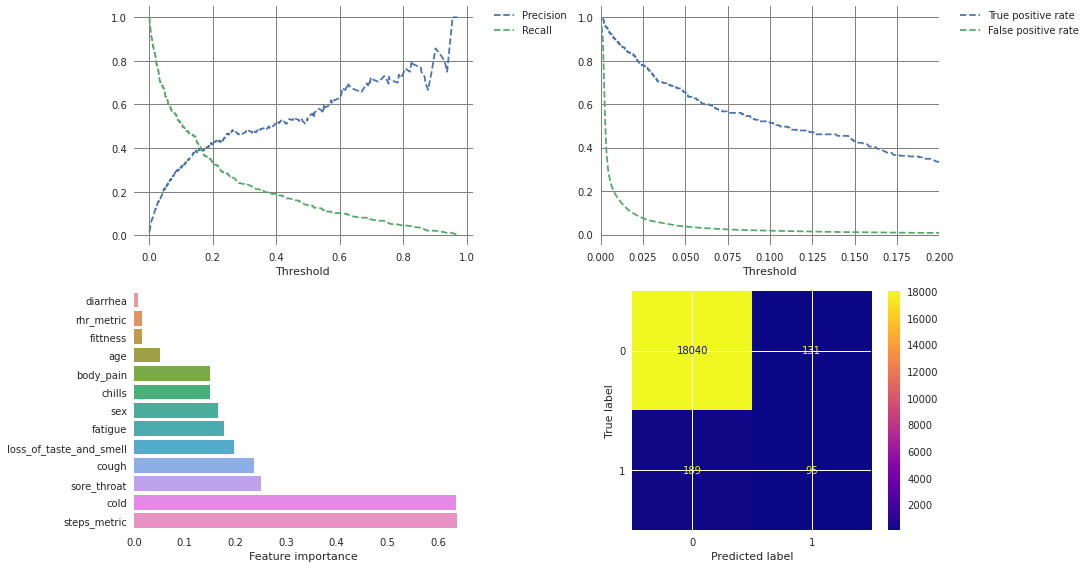

In [28]:


feature_names = [
    "rhr_metric",
    "steps_metric",
    "chills",
    "body_pain",
    "loss_of_taste_and_smell",
    "fatigue",
    "cough",
    "cold",
    "diarrhea",
    "sore_throat",
    "fittness",
    "sex",
    "age"
]
target = 'test_result'

pipeline, X_test, y_test = train_model(feature_names, target, cleaned_feature_data)


def plot_feature_importance(ax, classifier, feature_names):
    lr = classifier.get_params()['logisticregression']
    values, feature_names_sorted = zip(*sorted(zip(abs(lr.coef_[0]), feature_names)))
    sns.barplot(y=list(feature_names_sorted), x=list(values), ax=ax)
    ax.set_xlabel("Feature importance")

def plot_confusion_matrix_with_threshold(ax, classifier, X_test, threshold):
    proba = classifier.predict_proba(X_test)
    y_pred = (proba > threshold).T[1]
    cm = confusion_matrix(y_test, y_pred, sample_weight=None,
                          labels=None, normalize=None)
    display_labels = pipeline.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    disp.plot(include_values=True,
                     cmap='plasma', ax=ax, xticks_rotation='horizontal',
                     values_format=None)

def plot_precision_recall_vs_thresholds(ax, classifier, X_test):
    proba = classifier.predict_proba(X_test)
    precisions, recalls, thresholds = precision_recall_curve(y_test, proba.T[1])
    ax.plot(thresholds, precisions[:-1], "--", label="Precision")
    ax.plot(thresholds, recalls[:-1], "--", label="Recall")
    ax.set_xlabel("Threshold")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

def plot_roc_vs_threshold(ax, classifier, X_test):
    proba = classifier.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, proba.T[1])
    ax.plot(thresholds, true_positive_rate, "--", label="True positive rate")
    ax.plot(thresholds, false_positive_rate, "--", label="False positive rate")
    ax.set_xlabel("Threshold")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
    ax.set_xlim([0, 0.2])

with plt.style.context('seaborn'):
    plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.3),  # white   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.5),  # white with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.2),  # white  with alpha = 20%
})
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))

    plot_precision_recall_vs_thresholds(axes[0][0], pipeline, X_test)
    plot_roc_vs_threshold(axes[0][1], pipeline, X_test)
    plot_feature_importance(axes[1][0], pipeline, feature_names)
    plot_confusion_matrix_with_threshold(axes[1][1], pipeline, X_test, 0.2)

    fig.tight_layout()

    fig.savefig('model_metrics.png')

In [5]:
cleaned_features = feature_data.dropna(axis=0, subset=feature_names)

In [6]:
# Load reported incidences from File
online_source = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Inzidenz_Impfstatus.html'
from datetime import datetime

local_source = os.path.join(os.path.dirname(notebook_path), 'Inzidenz_Impfstatus.xlsx')

def load_excel(path):
    data = pd.read_excel(
        path,
        sheet_name=1, header=3
    )[['Mit Auffrischimpfung 18-59 Jahre', 'Grundimmunisierte  18-59 Jahre', 'Ungeimpfte 18-59 Jahre'
        , 'Meldejahr', 'Meldewoche']]
    data['date'] = data.apply(
        lambda row: datetime.strptime(str(row['Meldejahr']) + "-" + str(row['Meldewoche']) + '-1', "%Y-%W-%w"),
        axis=1)
    return data[data['Mit Auffrischimpfung 18-59 Jahre'] != '--'].drop(columns=['Meldejahr', 'Meldewoche'])

try:
    incidence = load_excel(online_source)
except:
    incidence = load_excel(local_source)
incidence.head()

,Mit Auffrischimpfung 18-59 Jahre,Grundimmunisierte 18-59 Jahre,Ungeimpfte 18-59 Jahre,date
14,26.314556,56.442207,175.469131,2021-10-18
15,41.689949,76.105423,225.135971,2021-10-25
16,40.556797,93.186668,263.970917,2021-11-01
17,54.120281,117.041405,321.489929,2021-11-08
18,57.529449,136.188904,340.752441,2021-11-15


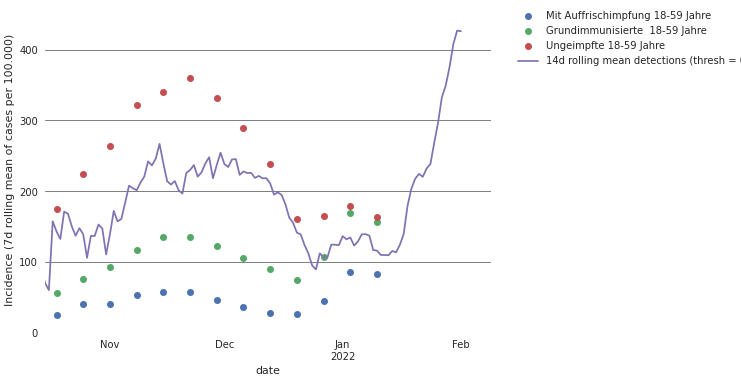

In [36]:
@R.curry
def predicted_incidence(params, plocal):
    threshold = params[0]

    p = plocal.copy()

    colname = f"14d rolling mean detections (thresh = {threshold})"

    p[colname] = p["probability"] > threshold

    p['all'] = p['probability'] > 0

    # if individuals are detected as infected in more than one week, take only the first detection
    filtered_cases = (p[p[colname] == True]
                      .reset_index()
                      .sort_values(['user_id', 'date'])
                      .groupby(['user_id'])
                      .agg({colname: 'first', 'all': 'first', 'date': lambda x: list(x)[0]})
                      .reset_index()
                      )

    tmp = pd.concat([filtered_cases, p[p[colname]==False].reset_index()])

    rolling_mean_detections = (
        tmp
            .groupby("date")
            .sum()
            .rolling('14D').mean()
            .drop(columns=["probability", "user_id"])
    )

    rolling_mean_detections.index = rolling_mean_detections.index

    rolling_mean_detections[colname] = rolling_mean_detections[colname].div(rolling_mean_detections['all'],
                                                                            axis=0) * 100_000

    return rolling_mean_detections.reset_index(), colname


proba_infected = pipeline.predict_proba(cleaned_features[feature_names].values).T[1].T

p = pd.DataFrame(
    data=proba_infected, index=cleaned_features.index, columns=["probability"]
)

df2, predicted_incidence_column = predicted_incidence([0.5, 0], p)
for df in [df2]:
    df.set_index('date', inplace=True)
    df.drop(columns=['all'], inplace=True)


with plt.style.context('seaborn'):
    plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.3),  # white   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.5),  # white with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.2),  # white  with alpha = 20%
    })

    fig, ax = plt.subplots(figsize=(8, 6))


    joined = incidence.set_index('date').join(df2, how='outer')
    joined.plot(ax=ax, style=['o', 'o', 'o', '-'])

    pdate = lambda date: datetime.strptime(date, '%Y-%m-%d')

    ax.set_xlim(R.map(pdate, ['2021-10-15', '2022-02-09']))
    ax.set_ylim([0, 460])
    ax.set_ylabel('Incidence (7d rolling mean of cases per 100.000)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(visible=True, which="both", axis="y", color='gray', linestyle='-', linewidth=1)

    fig.savefig('incidence_nowcast.png')